In [1]:
import polars as pl
import functools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize, least_squares
from IPython.display import clear_output
from matplotlib import ticker
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [2]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

def get_color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

In [3]:
loss_df = pl.read_csv("isoloss.csv")
flop_df = pl.read_csv("isoflops.csv")

In [4]:
loss_df

index,target_loss,steps,tokens,non_emb_flops_per_tok,total_flops_per_tok,non_emb_flops,total_flops,max_seq_len,hybrid_mixing_shift,num_layers,hidden_size,batch_size,lr,beta2,non_emb_params,total_params
i64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,f64,f64,i64,i64
0,3.709523,2009.953131,2.1076e9,3399975936,4154950656,7.1658e18,8.7569e18,2048,-1000,20,1536,512,0.5,0.98,566662656,969315840
0,3.680852,2077.375338,2.1783e9,3399975936,4154950656,7.4061e18,9.0507e18,2048,-1000,20,1536,512,0.5,0.98,566662656,969315840
0,3.652402,2145.910504,2.2502e9,3399975936,4154950656,7.6505e18,9.3493e18,2048,-1000,20,1536,512,0.5,0.98,566662656,969315840
0,3.624172,2218.216654,2.3260e9,3399975936,4154950656,7.9082e18,9.6643e18,2048,-1000,20,1536,512,0.5,0.98,566662656,969315840
0,3.596161,2297.750615,2.4094e9,3399975936,4154950656,8.1918e18,1.0011e19,2048,-1000,20,1536,512,0.5,0.98,566662656,969315840
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
592,4.4,3114.397241,2.0411e8,3399975936,4154950656,6.9395e17,8.4805e17,2048,0,20,1536,32,0.25,0.99,566662656,969315840
592,4.365992,3226.049121,2.1142e8,3399975936,4154950656,7.1883e17,8.7845e17,2048,0,20,1536,32,0.25,0.99,566662656,969315840
592,4.332247,3361.286727,2.2029e8,3399975936,4154950656,7.4896e17,9.1527e17,2048,0,20,1536,32,0.25,0.99,566662656,969315840


In [5]:
df_ = loss_df
df_ = df_.filter(df_["batch_size"] < 1024)

loss_targets = sorted(loss_df["target_loss"].unique())
def color(x, targets=loss_targets, cmap=plt.get_cmap("viridis_r")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))

min_y = float("inf")
max_y = float("-inf")

data = []
df_grouped = df_.group_by("hybrid_mixing_shift", "non_emb_params", "batch_size", "target_loss").agg(pl.all().sort_by("tokens").first())
for i, ((params,), dfi) in enumerate(df_grouped.sort("non_emb_params").group_by(["non_emb_params"])):
    for j, ((hybrid_mixing_shift,), dfj) in enumerate(dfi.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
        for k, ((target_loss,), dfk) in enumerate(dfj.sort("target_loss").group_by("target_loss")):
            dfk = dfk.sort("batch_size")
            xs = dfk["batch_size"].to_numpy()
            ys = dfk["tokens"].to_numpy()

            if len(xs) < 3:
                continue

            coeff = np.polyfit(np.log(xs), np.log(ys), 2)
            opt_batch_size = np.exp(-coeff[1] / (2 * coeff[0]))
            opt_tokens = np.exp(np.polyval(coeff, np.log(opt_batch_size)))
            if coeff[0] > 0 and opt_batch_size >= xs.min() and opt_batch_size <= xs.max():
                data.append({
                    "non_emb_params": params,
                    "hybrid_mixing_shift": hybrid_mixing_shift,
                    "opt_batch_size": opt_batch_size * 2048,
                    "opt_tokens": opt_tokens,
                })

opt_bs_df = pl.DataFrame(data)

In [15]:
df_ = flop_df
df_ = df_.filter(df_["batch_size"] < 1024)

flop_targets = sorted(flop_df["target_flops"].unique())
def color(x, targets=flop_targets, cmap=plt.get_cmap("viridis_r")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))

min_y = float("inf")
max_y = float("-inf")

data = []
df_grouped = df_.group_by("hybrid_mixing_shift", "non_emb_params", "batch_size", "tokens", "lr").agg(pl.all().sort_by("loss").first())
for i, ((params,), dfi) in enumerate(df_grouped.sort("non_emb_params").group_by(["non_emb_params"])):
    for j, ((hybrid_mixing_shift,), dfj) in enumerate(dfi.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
        for k, ((batch_size, tokens), dfk) in enumerate(dfj.sort("batch_size").group_by("batch_size", "tokens")):
            dfk = dfk.sort("lr")
            xs = dfk["lr"].to_numpy()
            ys = dfk["loss"].to_numpy()

            m = np.isfinite(ys)
            xs = xs[m]
            ys = ys[m]

            if len(xs) < 3:
                continue
            # print(xs, ys)

            coeff = np.polyfit(np.log(xs), np.log(ys), 2)
            opt_lr = np.exp(-coeff[1] / (2 * coeff[0]))
            opt_loss = np.exp(np.polyval(coeff, np.log(opt_lr)))
            if coeff[0] > 0 and opt_lr >= xs.min() and opt_lr <= xs.max():
                data.append({
                    "non_emb_params": params,
                    "hybrid_mixing_shift": hybrid_mixing_shift,
                    "opt_lr": opt_lr,
                    "opt_loss": opt_loss,
                    "batch_size": batch_size * 2048,
                    "tokens": tokens,
                    "target_flops": dfk["target_flops"][0],
                })

opt_lr_df = pl.DataFrame(data)

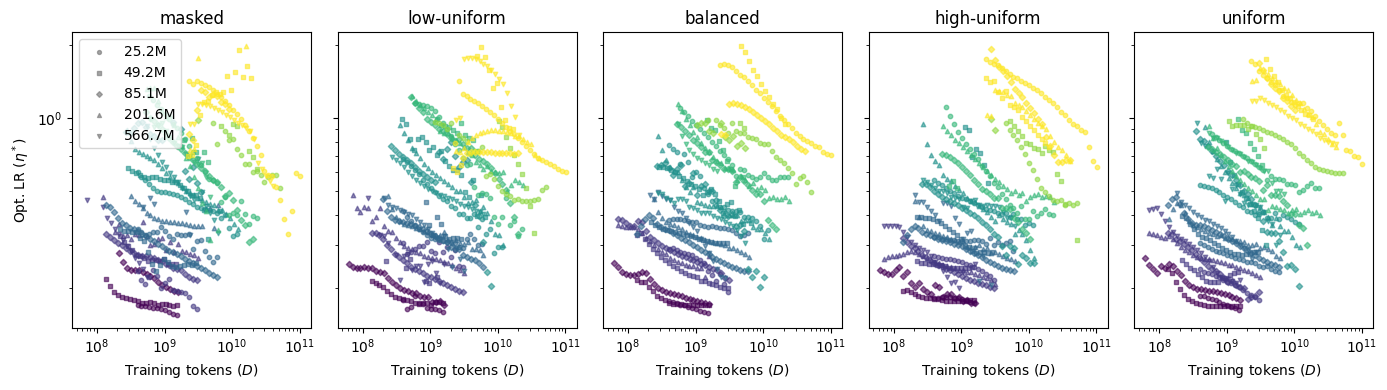

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4), sharey="row", sharex=True)

def color(x, vmax=512*2048, vmin=8*2048, cmap=plt.get_cmap("viridis")):
    return cmap((np.log10(x) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin)))

plt_idx = 0
for (hybrid_mixing_shift,), dfi in opt_lr_df.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift"):
    ax = axs[plt_idx]
    plt_idx += 1
    for j, ((batch_size,), dfj) in enumerate(dfi.sort(["batch_size"]).group_by(["batch_size"])):
        c = color(batch_size)
        for k, ((non_emb_params,), dfk) in enumerate(dfj.sort(["non_emb_params"]).group_by(["non_emb_params"])):
            ax.scatter(dfk["tokens"], dfk["opt_lr"], alpha=0.6, s=10, color=c, marker=["o", "s", "D", "^", "v"][k])

    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")
    ax.set_xlabel("Training tokens ($D$)")
    ax.set_xscale("log")
    ax.set_yscale("log")

ax = axs[0]
ax.set_ylabel("Opt. LR ($\\eta^*$)")

for k, ((non_emb_params,), _) in enumerate(opt_lr_df.sort(["non_emb_params"]).group_by(["non_emb_params"])):
    ax.scatter([], [], alpha=0.7, s=8, color="gray", marker=["o", "s", "D", "^", "v"][k], label=f"{non_emb_params/1e6:.1f}M")

ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/opt_lr_vs_tokens_by_noise.pdf", bbox_inches="tight")

In [20]:
def get_optimal_bs(tokens):
    return 10**(-2.4) * tokens**0.8225

data = []
plt_idx = 0
for (hybrid_mixing_shift,), dfi in opt_lr_df.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift"):
    ax = axs[plt_idx]
    plt_idx += 1
    for j, ((non_emb_params,), dfj) in enumerate(dfi.sort(["non_emb_params"]).group_by(["non_emb_params"])):
        for k, ((tokens,), dfk) in enumerate(dfj.sort(["tokens"]).group_by(["tokens"])):
            xs = dfk["batch_size"]
            ys = dfk["opt_lr"]
            if len(xs) < 2:
                continue
            coeff = np.polyfit(np.log(xs), np.log(ys), 1)
            opt_x = get_optimal_bs(tokens)
            opt_y = np.exp(np.polyval(coeff, np.log(opt_x)))
            if opt_x >= xs.min() and opt_x <= xs.max():
                data.append({
                    "hybrid_mixing_shift": hybrid_mixing_shift,
                    "non_emb_params": non_emb_params,
                    "tokens": tokens,
                    "opt_batch_size": opt_x,
                    "opt_lr": opt_y,
                })

opt_lr_by_bs_df = pl.DataFrame(data)

/tmp/ipykernel_541024/3391991661.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs, ys, s=ss, c=color, alpha=0.3)


[ 0.77592345 -4.44879491]
[ 0.79164573 -4.83735111]
[ 0.83728807 -5.84524593]
[ 0.86066336 -6.39774123]
[ 0.87870275 -6.79178375]


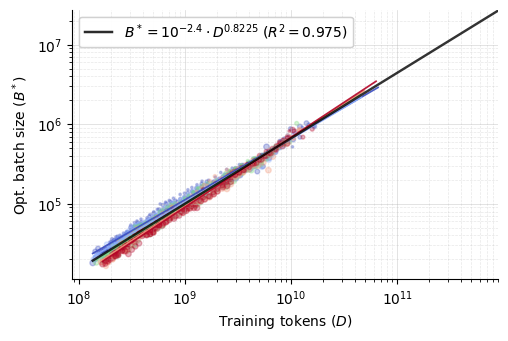

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5), sharey="row", sharex=True)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]

for (hybrid_mixing_shift,), dfi in opt_bs_df.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift"):
    color = get_color(hybrid_mixing_shift)
    xs = dfi["opt_tokens"].to_numpy()
    ys = dfi["opt_batch_size"].to_numpy()
    params = np.log(dfi["non_emb_params"].to_numpy())**2
    ss = 13*(params - params.min()) / (params.max() - params.min()) + 3
    ax.scatter(xs, ys, s=ss, c=color, alpha=0.3)

    coeff = np.polyfit(np.log(xs), np.log(ys), 1)
    # fit without intercept
    # a = np.linalg.lstsq(np.log(xs[:, None]), np.log(ys))[0]
    x_fit = np.logspace(np.log10(xs.min()), np.log10(4*xs.max()))
    y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
    ax.plot(x_fit, y_fit, color=color, linestyle="-", alpha=0.9, linewidth=1.25)
    ax.plot([], [], color=color, linestyle="-", label=f"{get_noise_label(hybrid_mixing_shift)}")
    print(coeff)

# main_legend = ax.legend(loc="lower right", edgecolor="white", framealpha=0.5)
# leg = ax.add_artist(main_legend)

xs = opt_bs_df["opt_tokens"].to_numpy()
ys = opt_bs_df["opt_batch_size"].to_numpy()
coeff = np.polyfit(np.log(xs), np.log(ys), 1)
r2 = np.corrcoef(np.log(ys), np.polyval(coeff, np.log(xs)))[0, 1]**2
x_fit = np.logspace(np.log10(xs.min()), np.log10(1e12))
y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
s = ax.plot(x_fit, y_fit, linestyle="-", color="black", alpha=0.8, linewidth=1.75, label="$B^* = 10^{{{:.4g}}} \\cdot D^{{{:.4g}}}$ ($R^2 = {:.3g}$)".format(coeff[1] / np.log(10), coeff[0], r2))
trend_legend = ax.legend(handles=s, loc="upper left")
leg = ax.add_artist(trend_legend)

# ax.legend(loc="lower right")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Training tokens ($D$)")
ax.set_ylabel("Opt. batch size ($B^*$)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(None, 9e11)
ax.set_ylim(None, 1.35e4 * 2048)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3)

# fig.tight_layout()
fig.savefig("plots/opt_batch_size_vs_tokens.pdf", bbox_inches="tight")

/tmp/ipykernel_541024/3080222850.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs, ys, s=ss, c=color, alpha=0.5)


[ 0.27098776 -6.38971242]
[ 0.24046957 -5.7501864 ]
[ 0.30048333 -7.03530517]
[ 0.29840419 -7.05212385]
[ 0.29235122 -6.89732224]


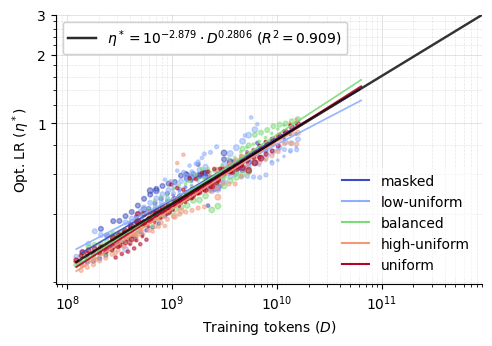

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5), sharey="row", sharex=True)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]

for (hybrid_mixing_shift,), dfi in opt_lr_by_bs_df.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift"):
    color = get_color(hybrid_mixing_shift)
    xs = dfi["tokens"].to_numpy()
    ys = dfi["opt_lr"].to_numpy()
    params = np.log(dfi["non_emb_params"].to_numpy())**2
    ss = 13*(params - params.min()) / (params.max() - params.min()) + 3
    ax.scatter(xs, ys, s=ss, c=color, alpha=0.5)

    coeff = np.polyfit(np.log(xs), np.log(ys), 1)
    # fit without intercept
    # a = np.linalg.lstsq(np.log(xs[:, None]), np.log(ys))[0]
    x_fit = np.logspace(np.log10(xs.min()), np.log10(4*xs.max()))
    y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
    ax.plot(x_fit, y_fit, color=color, linestyle="-", alpha=0.9, linewidth=1.25)
    ax.plot([], [], color=color, linestyle="-", label=f"{get_noise_label(hybrid_mixing_shift)}")
    print(coeff)

main_legend = ax.legend(loc="lower right", edgecolor="white", framealpha=0.5)
leg = ax.add_artist(main_legend)

xs = opt_lr_by_bs_df["tokens"].to_numpy()
ys = opt_lr_by_bs_df["opt_lr"].to_numpy()
coeff = np.polyfit(np.log(xs), np.log(ys), 1)
r2 = np.corrcoef(np.log(ys), np.polyval(coeff, np.log(xs)))[0, 1]**2
x_fit = np.logspace(np.log10(xs.min()), np.log10(1e12))
y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
s = ax.plot(x_fit, y_fit, linestyle="-", color="black", alpha=0.8, linewidth=1.75, label="$\\eta^* = 10^{{{:.4g}}} \\cdot D^{{{:.4g}}}$ ($R^2 = {:.3g}$)".format(coeff[1] / np.log(10), coeff[0], r2))
trend_legend = ax.legend(handles=s, loc="upper left", frameon=True)
leg = ax.add_artist(trend_legend)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Training tokens ($D$)")
ax.set_ylabel("Opt. LR ($\\eta^*$)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([1.0 * i for i in range(1, 5)], [f"{i:.0f}" for i in range(1, 5)], minor=False)
ax.set_yticks([0.2 * i for i in range(1, 32)], ["" for i in range(1, 32)], minor=True)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3)

ax.set_xlim(None, 9e11)
ax.set_ylim(None, 3.0)

# fig.tight_layout()
fig.savefig("plots/opt_lr_vs_tokens.pdf", bbox_inches="tight")

/tmp/ipykernel_541024/2984859784.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs, ys, s=ss, c=color, alpha=0.5)


[ 0.3294684  -4.56900274]
[ 0.29236422 -4.13452199]
[ 0.36532928 -5.01642097]
[ 0.36280144 -5.04720897]
[ 0.35544221 -4.93307601]


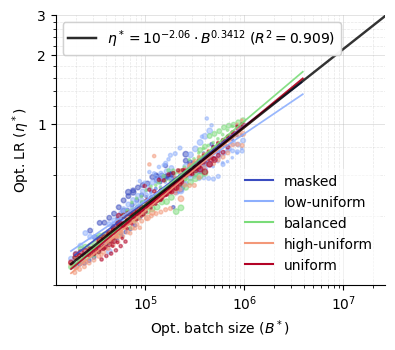

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5), sharey="row", sharex=True)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]

for (hybrid_mixing_shift,), dfi in opt_lr_by_bs_df.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift"):
    color = get_color(hybrid_mixing_shift)
    xs = dfi["opt_batch_size"].to_numpy()
    ys = dfi["opt_lr"].to_numpy()
    params = np.log(dfi["non_emb_params"].to_numpy())**2
    ss = 13*(params - params.min()) / (params.max() - params.min()) + 3
    ax.scatter(xs, ys, s=ss, c=color, alpha=0.5)

    coeff = np.polyfit(np.log(xs), np.log(ys), 1)
    # fit without intercept
    # a = np.linalg.lstsq(np.log(xs[:, None]), np.log(ys))[0]
    x_fit = np.logspace(np.log10(xs.min()), np.log10(4*xs.max()))
    y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
    ax.plot(x_fit, y_fit, color=color, linestyle="-", alpha=0.9, linewidth=1.25)
    ax.plot([], [], color=color, linestyle="-", label=f"{get_noise_label(hybrid_mixing_shift)}")
    print(coeff)

main_legend = ax.legend(loc="lower right", edgecolor="white", framealpha=0.5)
leg = ax.add_artist(main_legend)

xs = opt_lr_by_bs_df["opt_batch_size"].to_numpy()
ys = opt_lr_by_bs_df["opt_lr"].to_numpy()
coeff = np.polyfit(np.log(xs), np.log(ys), 1)
r2 = np.corrcoef(np.log(ys), np.polyval(coeff, np.log(xs)))[0, 1]**2
x_fit = np.logspace(np.log10(xs.min()), np.log10(1e12))
y_fit = np.exp(np.polyval(coeff, np.log(x_fit)))
s = ax.plot(x_fit, y_fit, linestyle="-", color="black", alpha=0.8, linewidth=1.75, label="$\\eta^* = 10^{{{:.4g}}} \\cdot B^{{{:.4g}}}$ ($R^2 = {:.3g}$)".format(coeff[1] / np.log(10), coeff[0], r2))
trend_legend = ax.legend(handles=s, loc="upper left", frameon=True)
leg = ax.add_artist(trend_legend)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Opt. batch size ($B^*$)")
ax.set_ylabel("Opt. LR ($\\eta^*$)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([1.0 * i for i in range(1, 5)], [f"{i:.0f}" for i in range(1, 5)], minor=False)
ax.set_yticks([0.2 * i for i in range(1, 32)], ["" for i in range(1, 32)], minor=True)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3)

ax.set_xlim(1.25e4, 2.65e7)
ax.set_ylim(0.2, 3.0)

# fig.tight_layout()
fig.savefig("plots/opt_lr_vs_opt_bs.pdf", bbox_inches="tight")

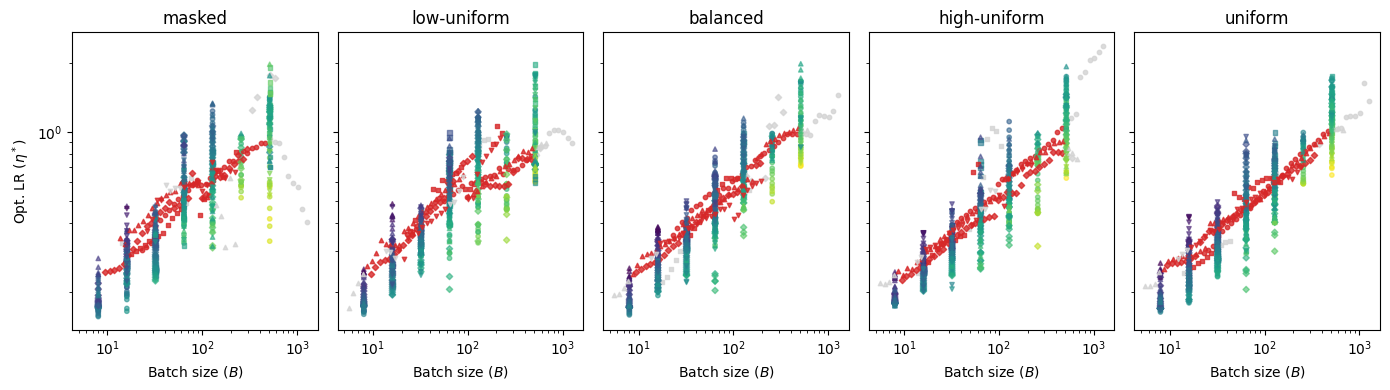

In [297]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4), sharey="row", sharex=True)

def get_optimal_bs(tokens):
    return 10**(-5.712) * tokens**0.8225

vmin, vmax = opt_lr_df["tokens"].min(), opt_lr_df["tokens"].max()
def color(x, max=vmax, min=vmin, cmap=plt.get_cmap("viridis")):
    return cmap((np.log10(x) - np.log10(min)) / (np.log10(max) - np.log10(min)))

data = []
plt_idx = 0
for (hybrid_mixing_shift,), dfi in opt_lr_df.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift"):
    ax = axs[plt_idx]
    plt_idx += 1
    for j, ((non_emb_params,), dfj) in enumerate(dfi.sort(["non_emb_params"]).group_by(["non_emb_params"])):
        ax.scatter(dfj["batch_size"], dfj["opt_lr"], alpha=0.6, s=10, c=np.log(dfj["tokens"]), vmin=np.log(vmin), vmax=np.log(vmax), marker=["o", "s", "D", "^", "v"][j])
        for k, ((tokens,), dfk) in enumerate(dfj.sort(["tokens"]).group_by(["tokens"])):
            xs = dfk["batch_size"]
            ys = dfk["opt_lr"]
            if len(xs) < 2:
                continue
            coeff = np.polyfit(np.log(xs), np.log(ys), 1)
            opt_x = get_optimal_bs(tokens)
            opt_y = np.exp(np.polyval(coeff, np.log(opt_x)))
            if opt_x >= xs.min() and opt_x <= xs.max():
                c = "C3"
                data.append({
                    "hybrid_mixing_shift": hybrid_mixing_shift,
                    "non_emb_params": non_emb_params,
                    "tokens": tokens,
                    "opt_batch_size": opt_x,
                    "opt_lr": opt_y,
                })
            else:
                c = "lightgray"
            ax.scatter(opt_x, opt_y, color=c, marker=["o", "s", "D", "^", "v"][j], s=10, alpha=0.8)

    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")
    ax.set_xlabel("Batch size ($B$)")
    ax.set_xscale("log")
    ax.set_yscale("log")

ax = axs[0]
ax.set_ylabel("Opt. LR ($\\eta^*$)")

for k, ((non_emb_params,), _) in enumerate(opt_lr_df.sort(["non_emb_params"]).group_by(["non_emb_params"])):
    ax.scatter([], [], alpha=0.7, s=8, color="gray", marker=["o", "s", "D", "^", "v"][k], label=f"{non_emb_params/1e6:.1f}M")

# ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/opt_lr_vs_bs_by_noise.pdf", bbox_inches="tight")